# An Exact Riemann solver for 1D Euler equation

## Governing Equation
The governing equation for the Riemann problem is the Euler equations

$$ \mathbf{U}_t+\mathbf{F}(\mathbf{U})_x = 0$$

where 

$$\mathbf{U} = \left[ \begin{align}
\rho\\
\rho u\\ 
E\\ 
\end{align} 
\right]
$$, $$
\mathbf{F} = \left[ \begin{align}
\rho u\\ \rho u^2+p\\ u(E+p)\\ 
\end{align} \right] $$

with initial conditions of

$$ \mathbf{U}(x,0) = \mathbf{U}^{(0)}(x)
= \left\{ \begin{align} 
\mathbf{U}_L,\quad \text{if} \quad x<0, \\
\mathbf{U}_R,\quad \text{if} \quad x>0, \\
\end{align} \right.
$$

And the EOS is

$$ e = \frac{p}{(\gamma-1)\rho}$$.


In [1]:
struct W
    ρ::Float64
    u::Float64
    p::Float64
end

## Solving method

In the Star region, we establish a function of the pressure $p^*$ with the velocity $u^*$ on left and right sepratively.
### Left function 
$$f_L(p, \mathbf{W}_L) = \left\{ \begin{align} 
(p-p_L)\left[\frac{A_L}{p+B_L}\right]^{1/2} \quad \text{if} \quad p>p_L \quad \text(shock),\\
\frac{2a_L}{\gamma -1} \left[ \left(\frac{p}{p_L}\right)^{\frac{\gamma-1}{2\gamma}} -1\right] \quad \text{if} \quad p\le p_L \quad \text{(rarefaction)}
\end{align} \right.
$$
and the data-dependent constants $A_L, B_L, A_R,B_R$ are given by
$$ \left. \begin{array}{ll}
      A_L = \frac{2}{(\gamma+1)\rho_L},& B_L = \frac{(\gamma -1)}{(\gamma +1)}p_L,\\
      A_R = \frac{2}{(\gamma+1)\rho_R},& B_R = \frac{(\gamma -1)}{(\gamma +1)}p_R,\\
      \end{array}\right\} $$

In [2]:
function f(p::Float64,W₀::W,γ::Float64)
    ρ₀,u₀,p₀ = W₀.ρ,W₀.u,W₀.p
    
    A = 2/((γ +1 )*ρ₀)
    B = (γ-1)/(γ+1)*p₀
    
    if p>p₀ 
        return (p-p₀)*√(A/(p+B))
    else
        a₀ = √(γ*p₀/ρ₀)
        return 2a₀/(γ-1)*((p/p₀)^((γ-1)/2/γ) -1)
    end
end    

f (generic function with 1 method)

$$\rho_L^* = \rho_L(p^*/p_L)^{1/\gamma}$$
$$u^* = u_L -f_L(p^*,W_L)$$

$$\rho_R^* = \rho_R(p^*/p_R)^{1/\gamma}$$
$$u^* = u_R +f_R(p^*,W_R)$$

In [17]:
function ρₚ(p::Float64,W₀::W,γ::Float64)
    if p < W₀.p
       return W₀.ρ*(p/W₀.p)^(1/γ)
    else 
        return W₀.ρ*((γ-1)/(γ+1)+p/W₀.p)/((γ-1)/(γ+1)*p/W₀.p+1)
    end
end

ρₚ (generic function with 1 method)

In [7]:
function Derivative(f::Function,x::Float64)
    ϵ₀ = 1e-10
    if abs(x) >= ϵ₀
        ϵ= ϵ₀*x
    else
        ϵ =ϵ₀
    end
    f¹(x) = (f(x+ϵ)-f(x))/ϵ
    return f¹(x)
end

Derivative (generic function with 1 method)

In [5]:
    fₗ(p) = f(p,Wₗ,γ)
    fᵣ(p) = f(p,Wᵣ,γ)
    F(p) = fₗ(p) + fᵣ(p)+Wᵣ.u-Wₗ.u
    F¹(p) = Derivative(p->F(p),p)

F¹ (generic function with 1 method)

## Newton iteration 

We use the Newton iteration method to solve
$$f_L(p) +f_R(p)+ u_R-u_L = 0$$

In [57]:
function RiemannSolver(Wₗ::W,Wᵣ::W,γ::Float64)    
   #     γ = 1.4
     p = (Wₗ.p + Wᵣ.p)/2
     TOL = 1.0e-6
     while true
        F₁ = F(p)
         p1 = p- F₁/F¹(p)
         if max(abs(F₁),2*abs(p1-p)/(p1+p)) < TOL
            break
        end 
        p=p1
     #   @show p,F₁  
    end
    pStar = p
    uStar = Wₗ.u-fₗ(p)
    ρₗStar = ρₚ(p,Wₗ,γ)
    ρᵣStar = ρₚ(p,Wᵣ,γ)
    WₗStar = W(ρₗStar,uStar,pStar)
    WᵣStar = W(ρᵣStar,uStar,pStar)
    return WₗStar,WᵣStar
    return p
end

RiemannSolver (generic function with 1 method)

### A complete result
After Solving the states in the star regions, if we want to get a detailed ditribution, we can use the following function.


In [75]:
function SolveDistr(t::Float64,Wₗ::W,Wᵣ::W,γ::Float64)
    
    WₗStar,WᵣStar = RiemannSolver(Wₗ,Wᵣ,γ)
    
    ρₗStar,uStar, pStar =WₗStar.ρ,WₗStar.u,WₗStar.p
    ρᵣStar = WᵣStar.ρ
    ρₗ,pₗ,uₗ = Wₗ.ρ,Wₗ.p,Wₗ.u
    ρᵣ,pᵣ,uᵣ = Wᵣ.ρ,Wᵣ.p,Wᵣ.u
    
    I = 1200
    U = zeros(Float64,(I,3))
    x = zeros(Float64,I)
    if pStar > pₗ  # Left shock
        sL = (ρₗStar*uStar - ρₗ*uₗ)/(ρₗStar-ρₗ)
        for i =1:200
            x[i] = (2-0.005*(i-1))*sL*t
            U[i,:] = [ρₗ,uₗ,pₗ]
        end
        for i = 201:600
            x[i] = ((uStar-sL)/400*(i-200) + sL)*t
            U[i,:] = [ρₗStar,uStar,pStar]
        end
    else  # Left Rarefaction
        cL = √(γ*pₗ/ρₗ)
        cLStar = √(γ*pStar/ρₗStar)
        sLSlow = uₗ - cL
        sLFast = uStar - cLStar
        for i = 1:200
            x[i] =(2-0.005*(i-1))*sLSlow*t
            U[i,:] = [ρₗ,uₗ,pₗ]
        end
        
        x[201:400],U[201:400,:] = RareSpeedToU(t,Wₗ,pStar,γ,1)
        for i =401:600
            x[i] = ((uStar - sLFast)/200*(i-400) + sLFast)*t 
            U[i,:] = [ρₗStar,uStar,pStar]
        end 
    end
    
    if pStar > pᵣ  # Right shock
        sR = (ρᵣStar*uStar - ρᵣ*uᵣ)/(ρᵣStar-ρᵣ)
      #  @show ρᵣStar, ρᵣ
        for i =601:1000
            x[i] = ((-uStar+sR)/400*(i-600) + uStar)*t
            U[i,:] = [ρᵣStar,uStar,pStar]
        end
        for i = 1001:1200
            x[i] = (1+0.005*(i-1001))*sR*t
            U[i,:] = [ρᵣ,uᵣ,pᵣ]
        end
    else  # Right Rarefaction
        cR = √(γ*pᵣ/ρᵣ)
        cRStar = √(γ*pStar/ρᵣStar)
        sRFast = uᵣ + cR
        sRSlow = uStar + cRStar
        
        for i = 1000:1200
           x[i] =(1+0.005*(i-1001))*sRFast*t
            U[i,:] = [ρᵣ,uᵣ,pᵣ]
        end
        
        x[801:1000],U[801:1000,:] = RareSpeedToU(t,Wᵣ,pStar,γ,2)
        for i =601:800
             x[i] = ((-uStar + sRSlow)/200*(i-600) + uStar)*t 
             U[i,:] = [ρᵣStar,uStar,pStar]
        end 
    end
    return x, U
end

SolveDistr (generic function with 1 method)

In [90]:
function RareSpeedToU(t::Float64, W₀::W, p::Float64,γ::Float64,LoR::Int)
    ρ₀,u₀,p₀ = W₀.ρ, W₀.u,W₀.p
    
    x = zeros(Float64,200)
    U = zeros(Float64,(200,3))
    
    Δp = (p-p₀)/200
    
    for i in 1:200
        p = p₀ + Δp*(i-1)
        ρ = ρₚ(p, W₀, γ)
        c= √(γ*p/ρ)
        f₀ = f(p, W₀, γ)
        if LoR == 1
            u = u₀-f₀
            uc = u-c
        x[i] = uc*t
        U[i,1:3] = [ρ,u,p]
        else
            u = u₀+f₀
            uc = u+c
        x[200-i+1] = uc*t
        U[200-i+1,1:3] = [ρ,u,p]
        end
        
    end
    return x, U            
end

RareSpeedToU (generic function with 1 method)

In [91]:
Wₗ = W(1.0,0.0,1.0)
Wᵣ = W(0.125,0.0,0.1)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

([-0.236643, -0.236052, -0.23546, -0.234868, -0.234277, -0.233685, -0.233094, -0.232502, -0.23191, -0.231319  …  0.34167, 0.342546, 0.343423, 0.344299, 0.345175, 0.346051, 0.346927, 0.347803, 0.348679, 0.349555], [1.0 0.0 1.0; 1.0 0.0 1.0; … ; 0.125 0.0 0.1; 0.125 0.0 0.1])

In [92]:
using Plots
using LaTeXStrings
pyplot()

Plots.PyPlotBackend()

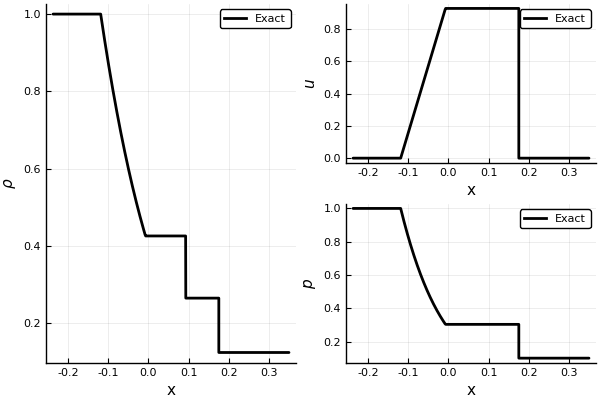

In [93]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

In [94]:
Wₗ = W(1.0,0.0,1000)
Wᵣ = W(1.0,0.0,0.01)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

([-7.48331, -7.46461, -7.4459, -7.42719, -7.40848, -7.38977, -7.37107, -7.35236, -7.33365, -7.31494  …  4.58592, 4.59768, 4.60944, 4.6212, 4.63295, 4.64471, 4.65647, 4.66823, 4.67999, 4.69175], [1.0 0.0 1000.0; 1.0 0.0 1000.0; … ; 1.0 0.0 0.01; 1.0 0.0 0.01])

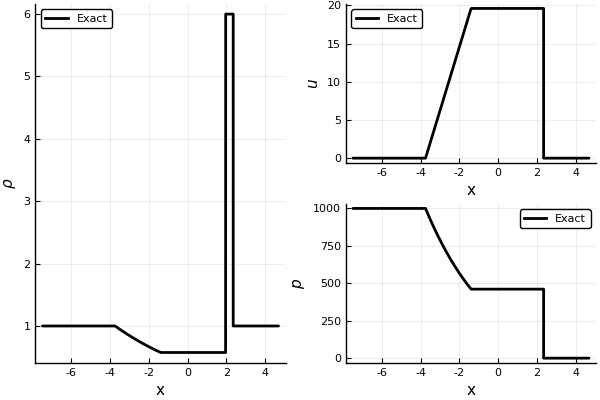

In [95]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

In [96]:
Wₗ = W(1.0,0.0,0.01)
Wᵣ = W(1.0,0.0,100)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

([-1.4875, -1.48378, -1.48006, -1.47634, -1.47262, -1.4689, -1.46518, -1.46146, -1.45775, -1.45403  …  2.30727, 2.31319, 2.3191, 2.32502, 2.33094, 2.33685, 2.34277, 2.34868, 2.3546, 2.36052], [1.0 0.0 0.01; 1.0 0.0 0.01; … ; 1.0 0.0 100.0; 1.0 0.0 100.0])

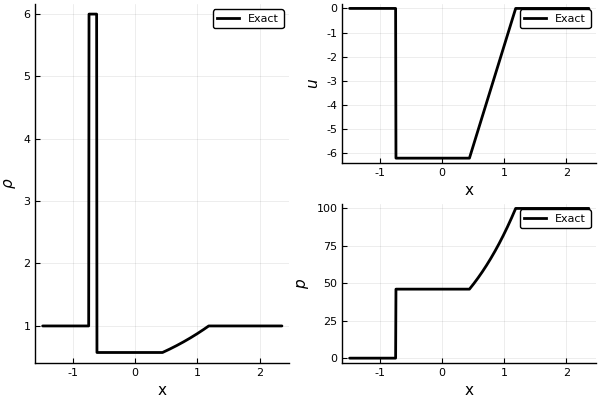

In [97]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)